In [99]:
! pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"sayansh001","key":"7414aeb1890d4a73a83b6a243eb750d4"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [100]:
!kaggle datasets download -d cdawn1/messy-vs-clean-room

messy-vs-clean-room.zip: Skipping, found more recently modified local copy (use --force to force download)


In [101]:
! unzip /content/messy-vs-clean-room.zip

Archive:  /content/messy-vs-clean-room.zip
replace images/images/test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Importing the Libraries**

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
from keras.preprocessing.image import load_img
from glob import glob

In [103]:
data = []
label = []

for class_name in os.listdir("/content/images/train"):
    for path in os.listdir("/content/images/train/"+class_name):
        if class_name == 'clean':
            label.append(0)
        else:
            label.append(1)
        data.append(os.path.join("/content/images/train", class_name, path))
print(data[0], label[0])

/content/images/train/messy/69.png 1


In [104]:
print(data[45],label[45])

/content/images/train/messy/56.png 1


In [105]:
len(data)

192

In [106]:
df = pd.DataFrame()
df['images']=data
df['label']=label
df = df.sample(frac=1).reset_index(drop=True)
#frac = 1 ensures that it will return all rows
df.head()

images  label
0  /content/images/train/clean/90.png      0
1  /content/images/train/clean/26.png      0
2  /content/images/train/messy/71.png      1
3  /content/images/train/messy/29.png      1
4  /content/images/train/messy/51.png      1

In [107]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

[]

Exploratory Data Analysis

To display grid of images

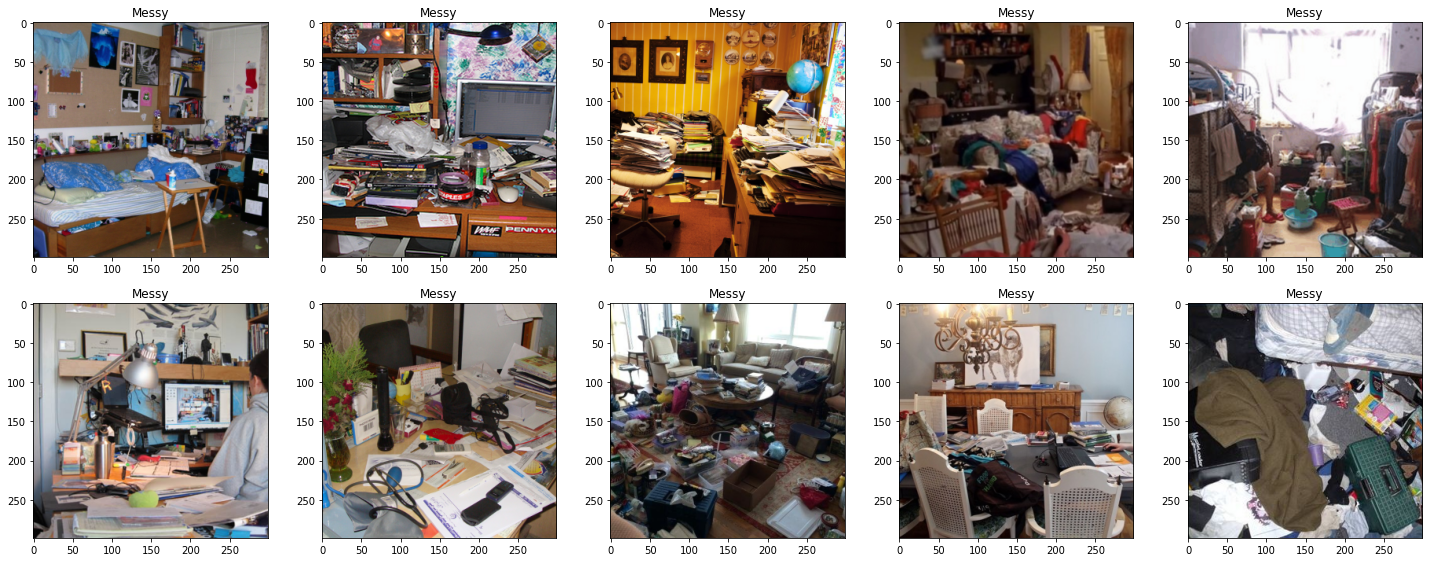

In [108]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']  #all the images of dogs will be stored in temp
start = random.randint(0,len(temp))  #this generates a random number between 0 and len(temp)
files = temp[start:start+25]         #in files we store the first 25 continuous images between the random number generated 
                                     #since temp is basically images of dogs from step 2
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Messy')
  plt.axis()

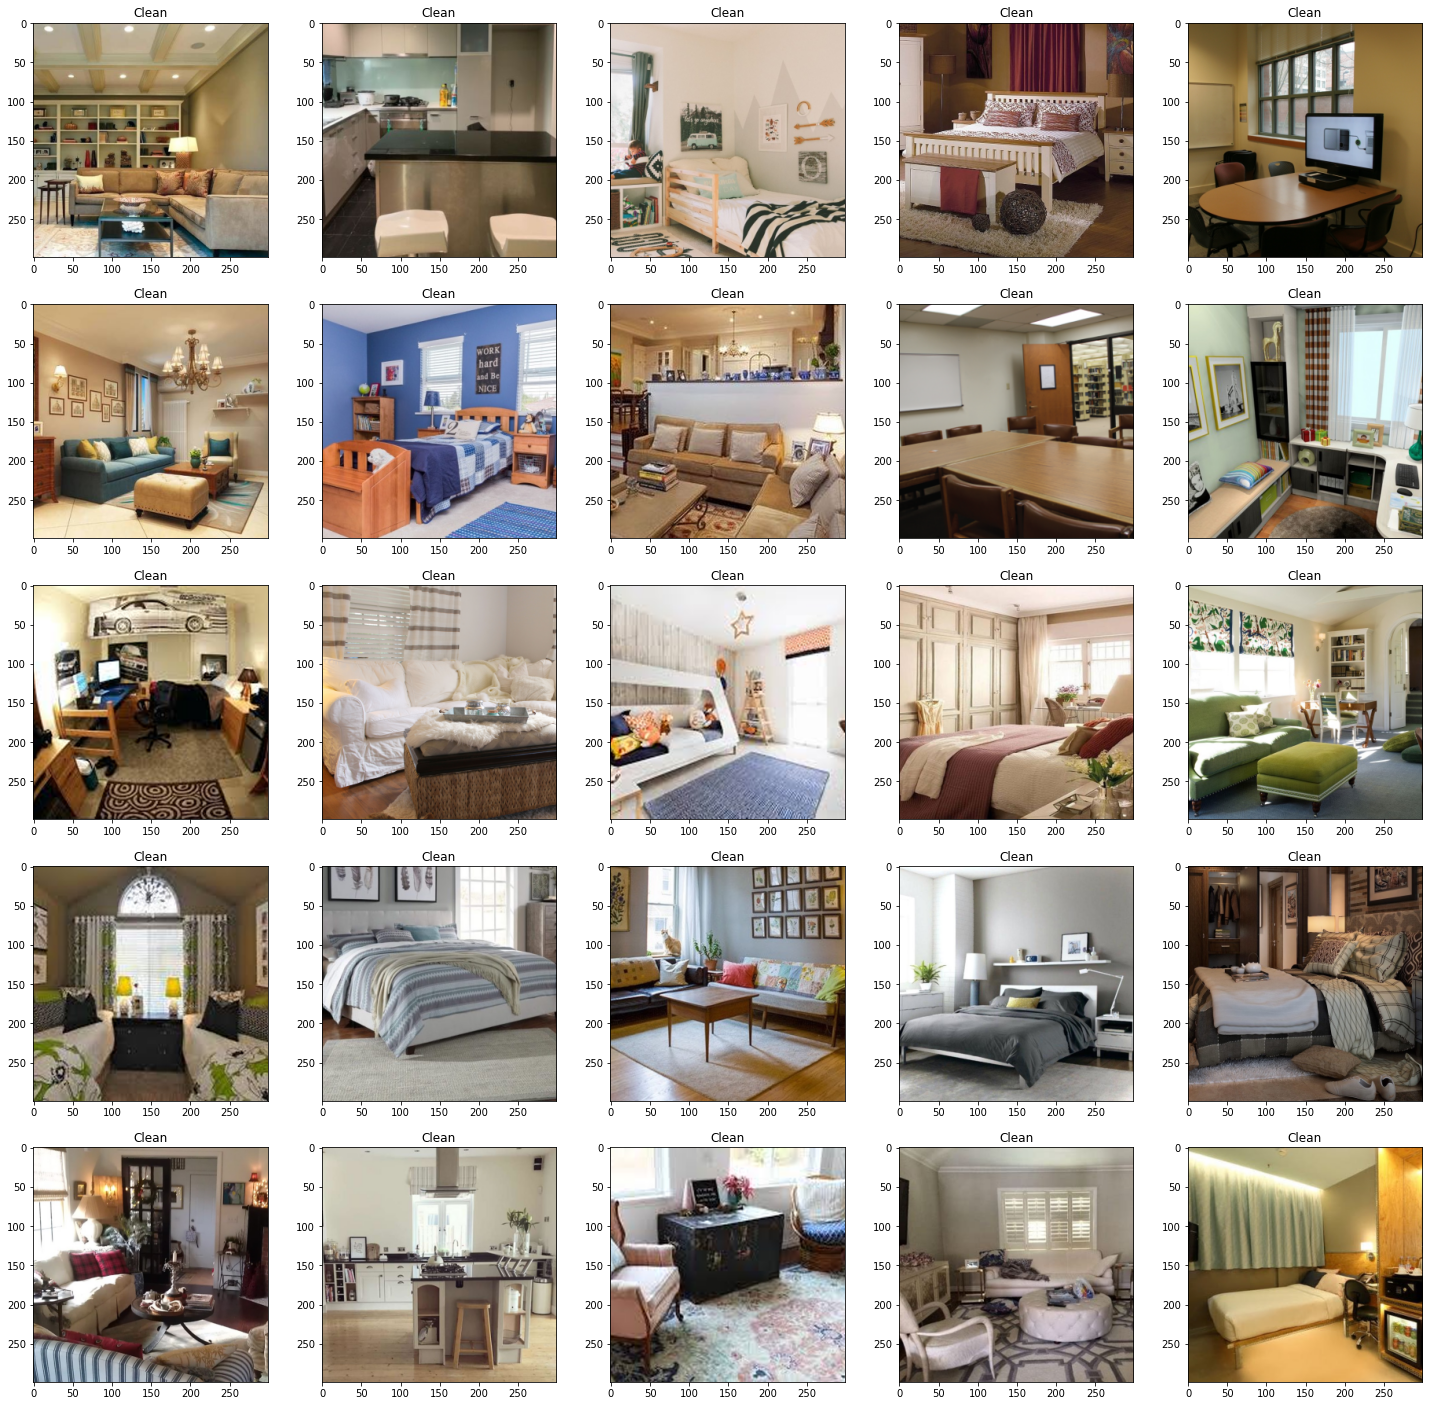

In [109]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']  #all the images of dogs will be stored in temp
start = random.randint(0,len(temp))  #this generates a random number between 0 and len(temp)
files = temp[start:start+25]         #in files we store the first 25 continuous images between the random number generated 
                                     #since temp is basically images of dogs from step 2
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Clean')
  plt.axis()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


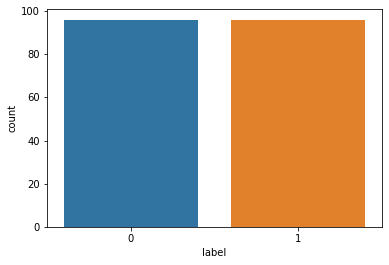

In [110]:
import seaborn as sns
sns.countplot(df['label'])

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  192 non-null    object
 1   label   192 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ KB


Create Data Generator for the Images

In [112]:
df['label'] = df['label'].astype('str')

In [113]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [114]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,   #Normalising the images to bring it between 0 and 1,easier for images to be processed
    #Augmentation purposes done to prevent overfitting
    rotation_range = 40,    
    shear_range = 0.2,         #it will slant the image
    zoom_range = 0.2,
    horizontal_flip = True,    #generate mirror image
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale=1./255)

#for loading the images 
train_iterator = train_generator.flow_from_dataframe(train,
                                                     x_col='images',
                                                     y_col='label',
                                                     target_size=(128,128),
                                                     batch_size=512,
                                                     class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(test,
                                                     x_col='images',
                                                     y_col='label',
                                                     target_size=(128,128),
                                                     batch_size=512,
                                                     class_mode='binary')

Found 153 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


Model Creation and Training

In [115]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout

model = Sequential([
                    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(64,(3,3),activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(128,(3,3),activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512,activation='relu'),
                    Dense(1,activation='sigmoid')
                   ])

In [116]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 128)     

In [117]:
history = model.fit(train_iterator, epochs=30, validation_data=val_iterator)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.6917 - accuracy: 0.5033 - val_loss: 1.3642 - val_accuracy: 0.5385
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 1.5384 - accuracy: 0.4902 - val_loss: 2.8557 - val_accuracy: 0.4615
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 2.6305 - accuracy: 0.5098 - val_loss: 1.5355 - val_accuracy: 0.4615
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 1.4151 - accuracy: 0.5098 - val_loss: 0.7953 - val_accuracy: 0.4615
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.7608 - accuracy: 0.5098 - val_loss: 0.7100 - val_accuracy: 0.4615
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.6822 - accuracy: 0.5098 - val_loss: 0.6315 - val_accuracy: 0.5897
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 0.6489 - accuracy: 0.7647 - val_loss: 0.6217 - val_accuracy: 0.6923
Epoch 8/30
1/1 [=========================

The model gives 80% accuracy on a custom built model which is quite decent

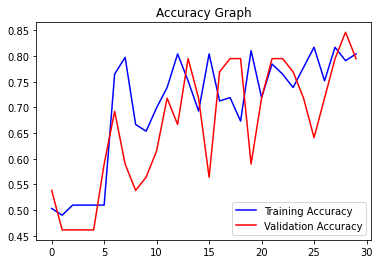

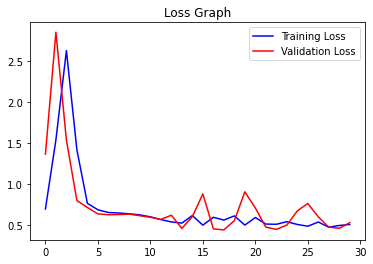

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [119]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"/content/images/test/3.png", target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_iterator.class_indices
if result[0][0] == 1:
  prediction = 'Messy'
else:
  prediction = 'Clean'
print(prediction)

Messy


In [120]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"/content/images/test/9.png", target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_iterator.class_indices
if result[0][0] == 1:
  prediction = 'Messy'
else:
  prediction = 'Clean'
print(prediction)

Clean


In [121]:
!pip install gradio

In [122]:
names=[]
for name in os.listdir('/content/images/train'):
    names.append(name) 
    names=sorted(names)
print(names)

['clean', 'messy']


In [123]:
import gradio as gr
def room_indentify(image):
  img=image.reshape(-1,128,128,3)
  pred=model.predict(img)
  return {names[i]: float(pred[i]) for i in range(1)}

In [124]:
image = gr.inputs.Image(shape=(128,128))
label = gr.outputs.Label(num_top_classes=2)

In [ ]:
gr.Interface(fn=room_indentify, inputs=image, outputs=label,interpretation='default').launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://52183.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
